In [254]:
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
import os
from collections import defaultdict

import seaborn as sns
import matplotlib as plt
from matplotlib import colors as mcolors
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint

In [255]:
%reload_ext dotenv
%dotenv -o

CITY_NAME = os.environ["CITY_NAME"]
CITY_SLUG = os.environ["CITY_SLUG"]
print(f"City name: {CITY_NAME}")
print(f"City slug: {CITY_SLUG}")

City name: Seattle, WA, USA
City slug: seattle


## Read data

This shouldn't take longer than ~40 sec.

### Load graph, separate to nodes and edges

In [256]:
# ~15 sec
with open(f"./data/{CITY_SLUG}_networkx_graph.pkl", "rb") as fin:
    G = pickle.load(fin)

og_edges = list(G.edges)
for u, v, i in og_edges:
    if i > 0:
        G.remove_edge(u, v, i)
    
print(f"Graph has:")
print(f"  {G.number_of_nodes():,} nodes")
print(f"  {G.number_of_edges():,} edges")

Graph has:
  37,088 nodes
  105,656 edges


In [257]:
"""
Seattle: 37k nodes, 106k edges -- 37 sec
"""

nodes, edges = ox.graph_to_gdfs(G)

In [258]:
def plot_base_network():
    fig, ax = plt.subplots()
    ox.plot_graph(
        G, ax=ax,
        figsize=(8, 8),
        bgcolor="#fff", edge_color="#000", node_color="#000",
        show=False, close=True,
        node_size=5, edge_linewidth=0.5
    )
    return fig, ax

### Load boba shop locations

In [259]:
# Hack from https://stackoverflow.com/questions/71907567/valueerror-geodataframe-does-not-support-multiple-columns-using-the-geometry-co
boba_gdf = gpd.read_file(f"./data/{CITY_SLUG}_boba_shops.csv",
                         GEOM_POSSIBLE_NAMES="geometry", 
                         KEEP_GEOM_COLUMNS="NO")
boba_gdf.head()

id                              alias  \
0  ozuMi1zz9jJkkikPLqNNSA                 jardin-tea-seattle   
1  M4BjcVhOEjVgeF8EeSjZPQ             oasis-tea-zone-seattle   
2  rFC0LUPyhgyP7UC9ehkrHw                jazen-tea-seattle-3   
3  I4pK6zZ4QwpmwVSTcDhH7A  yifang-taiwan-fruit-tea-seattle-3   
4  _L8WhDX0gwh1oMfpI7jdog                     tp-tea-seattle   

                      name                                          image_url  \
0               Jardin Tea  https://s3-media2.fl.yelpcdn.com/bphoto/E9nZd_...   
1           Oasis Tea Zone  https://s3-media3.fl.yelpcdn.com/bphoto/KBoQsS...   
2                Jazen Tea  https://s3-media2.fl.yelpcdn.com/bphoto/bCkCc7...   
3  Yifang Taiwan Fruit Tea  https://s3-media4.fl.yelpcdn.com/bphoto/l7-xpw...   
4                   TP TEA  https://s3-media3.fl.yelpcdn.com/bphoto/b_5pNZ...   

  is_closed                                                url review_count  \
0     False  https://www.yelp.com/biz/jardin-tea-seattle?ad...           75   
1     False  https://www.yelp.com/biz/oasis-tea-zone-seattl...          960   
2     False  https://www.yelp.com/biz/jazen-tea-seattle-3?a...           83   
3     False  https://www.yelp.com/biz/yifang-taiwan-fruit-t...           60   
4     False  https://www.yelp.com/biz/tp-tea-seattle?adjust...          298   

                                          categories rating  \
0  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...    4.0   
1  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...    3.5   
2  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...    4.0   
3  [{'alias': 'bubbletea', 'title': 'Bubble Tea'}...    3.0   
4    [{'alias': 'bubbletea', 'title': 'Bubble Tea'}]    4.0   

                                         coordinates            transactions  \
0  {'latitude': 47.5967969, 'longitude': -122.326...  ['delivery', 'pickup']   
1  {'latitude': 47.5976518611681, 'longitude': -1...            ['delivery']   
2  {'latitude': 47.5977133, 'longitude': -122.325...                      []   
3  {'latitude': 47.5982327, 'longitude': -122.325...  ['delivery', 'pickup']   
4  {'latitude': 47.5982676217916, 'longitude': -1...            ['delivery']   

                                            location         phone  \
0  {'address1': '600 5th Ave S', 'address2': 'Ste...  +12066881815   
1  {'address1': '519 6th Ave S', 'address2': '', ...  +12064478098   
2  {'address1': '618 S Weller St', 'address2': ''...  +12066247189   
3  {'address1': '619 S King St', 'address2': None...  +14255590956   
4  {'address1': '679 S King St', 'address2': '', ...  +12064857481   

    display_phone            distance price          latitude  \
0  (206) 688-1815  1963.6105183855282              47.5967969   
1  (206) 447-8098  1870.4787246704843     $  47.5976518611681   
2  (206) 624-7189   1879.296510779665     $        47.5977133   
3  (425) 559-0956  1820.3089974160932    $$        47.5982327   
4  (206) 485-7481  1841.2535169615815    $$  47.5982676217916   

           longitude                     geometry  
0       -122.3266681  POINT (-122.32745 47.59728)  
1  -122.326559026402  POINT (-122.32654 47.59772)  
2        -122.325291  POINT (-122.32552 47.59763)  
3       -122.3254515  POINT (-122.32549 47.59825)  
4  -122.323937863111  POINT (-122.32395 47.59824)

### Generate intersections of nearest boba shops

In [260]:
nodes.head(1)

y           x  street_count highway  ref  \
osmid                                                        
29936833  47.668047 -122.401954             1     NaN  NaN   

                             geometry  
osmid                                  
29936833  POINT (-122.40195 47.66805)

In [261]:
end_nodes = set()

for _, row in boba_gdf.iterrows():
    x, y = row["geometry"].x, row["geometry"].y
    node = ox.nearest_nodes(G, x, y)
    end_nodes.add(node)
    for edge in G.in_edges(node):
        end_nodes.add(edge[0])

end_nodes = list(end_nodes)

In [262]:
print(len(end_nodes), len(boba_gdf))

283 91


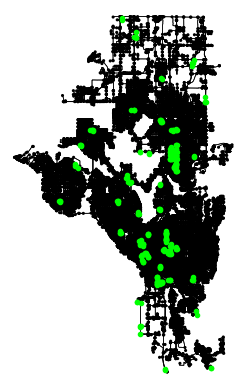

In [263]:
# Select rows of dataframe that match with endpoints
end_gdf = nodes.loc[end_nodes]

fig, ax = plot_base_network()
ax.plot(end_gdf["geometry"].x, end_gdf["geometry"].y, "o", markersize=3, c="#0f0")
fig

### Generate adjacency list

In [265]:
print("Imputing edge speeds...")
ox.speed.add_edge_speeds(G, hwy_speeds=(60 * 1.60934), fallback=(25 * 1.60934))
print("Imputing edge travel times...")
ox.speed.add_edge_travel_times(G)
print("Done.")

Imputing edge speeds...


Imputing edge travel times...
Done.


In [266]:
adj = defaultdict(list)
for u, v in tqdm(G.edges()):
    data = G.get_edge_data(u, v)[0]
    adj[u].append((v, data["travel_time"], round(data["length"], 3)))

  4%|▎         | 3869/105656 [00:00<00:02, 38679.98it/s]

100%|██████████| 105656/105656 [00:02<00:00, 43830.66it/s]


In [267]:
pprint(list(adj.items())[:10])

[(29936833, [(4964302857, 42.0, 281.122)]),
 (29937518, [(6292266884, 2.1, 14.159)]),
 (29937535, [(1752970209, 1.5, 9.769)]),
 (29937544, [(4695101006, 6.2, 41.514)]),
 (29937574,
  [(2669098044, 0.3, 2.161),
   (1298574786, 0.5, 3.564),
   (4358191433, 9.8, 65.886)]),
 (29937577, [(1725991339, 12.6, 84.135)]),
 (29937590, [(4694838696, 1.7, 11.609)]),
 (29937595, [(4694838709, 2.5, 16.621)]),
 (29937628,
  [(6209279624, 1.4, 9.215),
   (6209279620, 2.6, 17.53),
   (6975508418, 10.4, 69.908)]),
 (29937939, [(415169598, 14.0, 93.82)])]


In [274]:
# Color nodes based on their travel times as a santify check
edge_times = list(nx.get_edge_attributes(G, "travel_time").values())

def float_to_hex_color(float_list, colormap="viridis"):
    norm = plt.Normalize(min(float_list), max(float_list))
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
    hex_colors = [mcolors.to_hex(mapper.to_rgba(value)) for value in tqdm(float_list)]
    return hex_colors

edge_colors = float_to_hex_color(edge_times)

100%|██████████| 105656/105656 [00:56<00:00, 1856.96it/s]


  3%|▎         | 3383/105656 [01:24<42:42, 39.91it/s] 


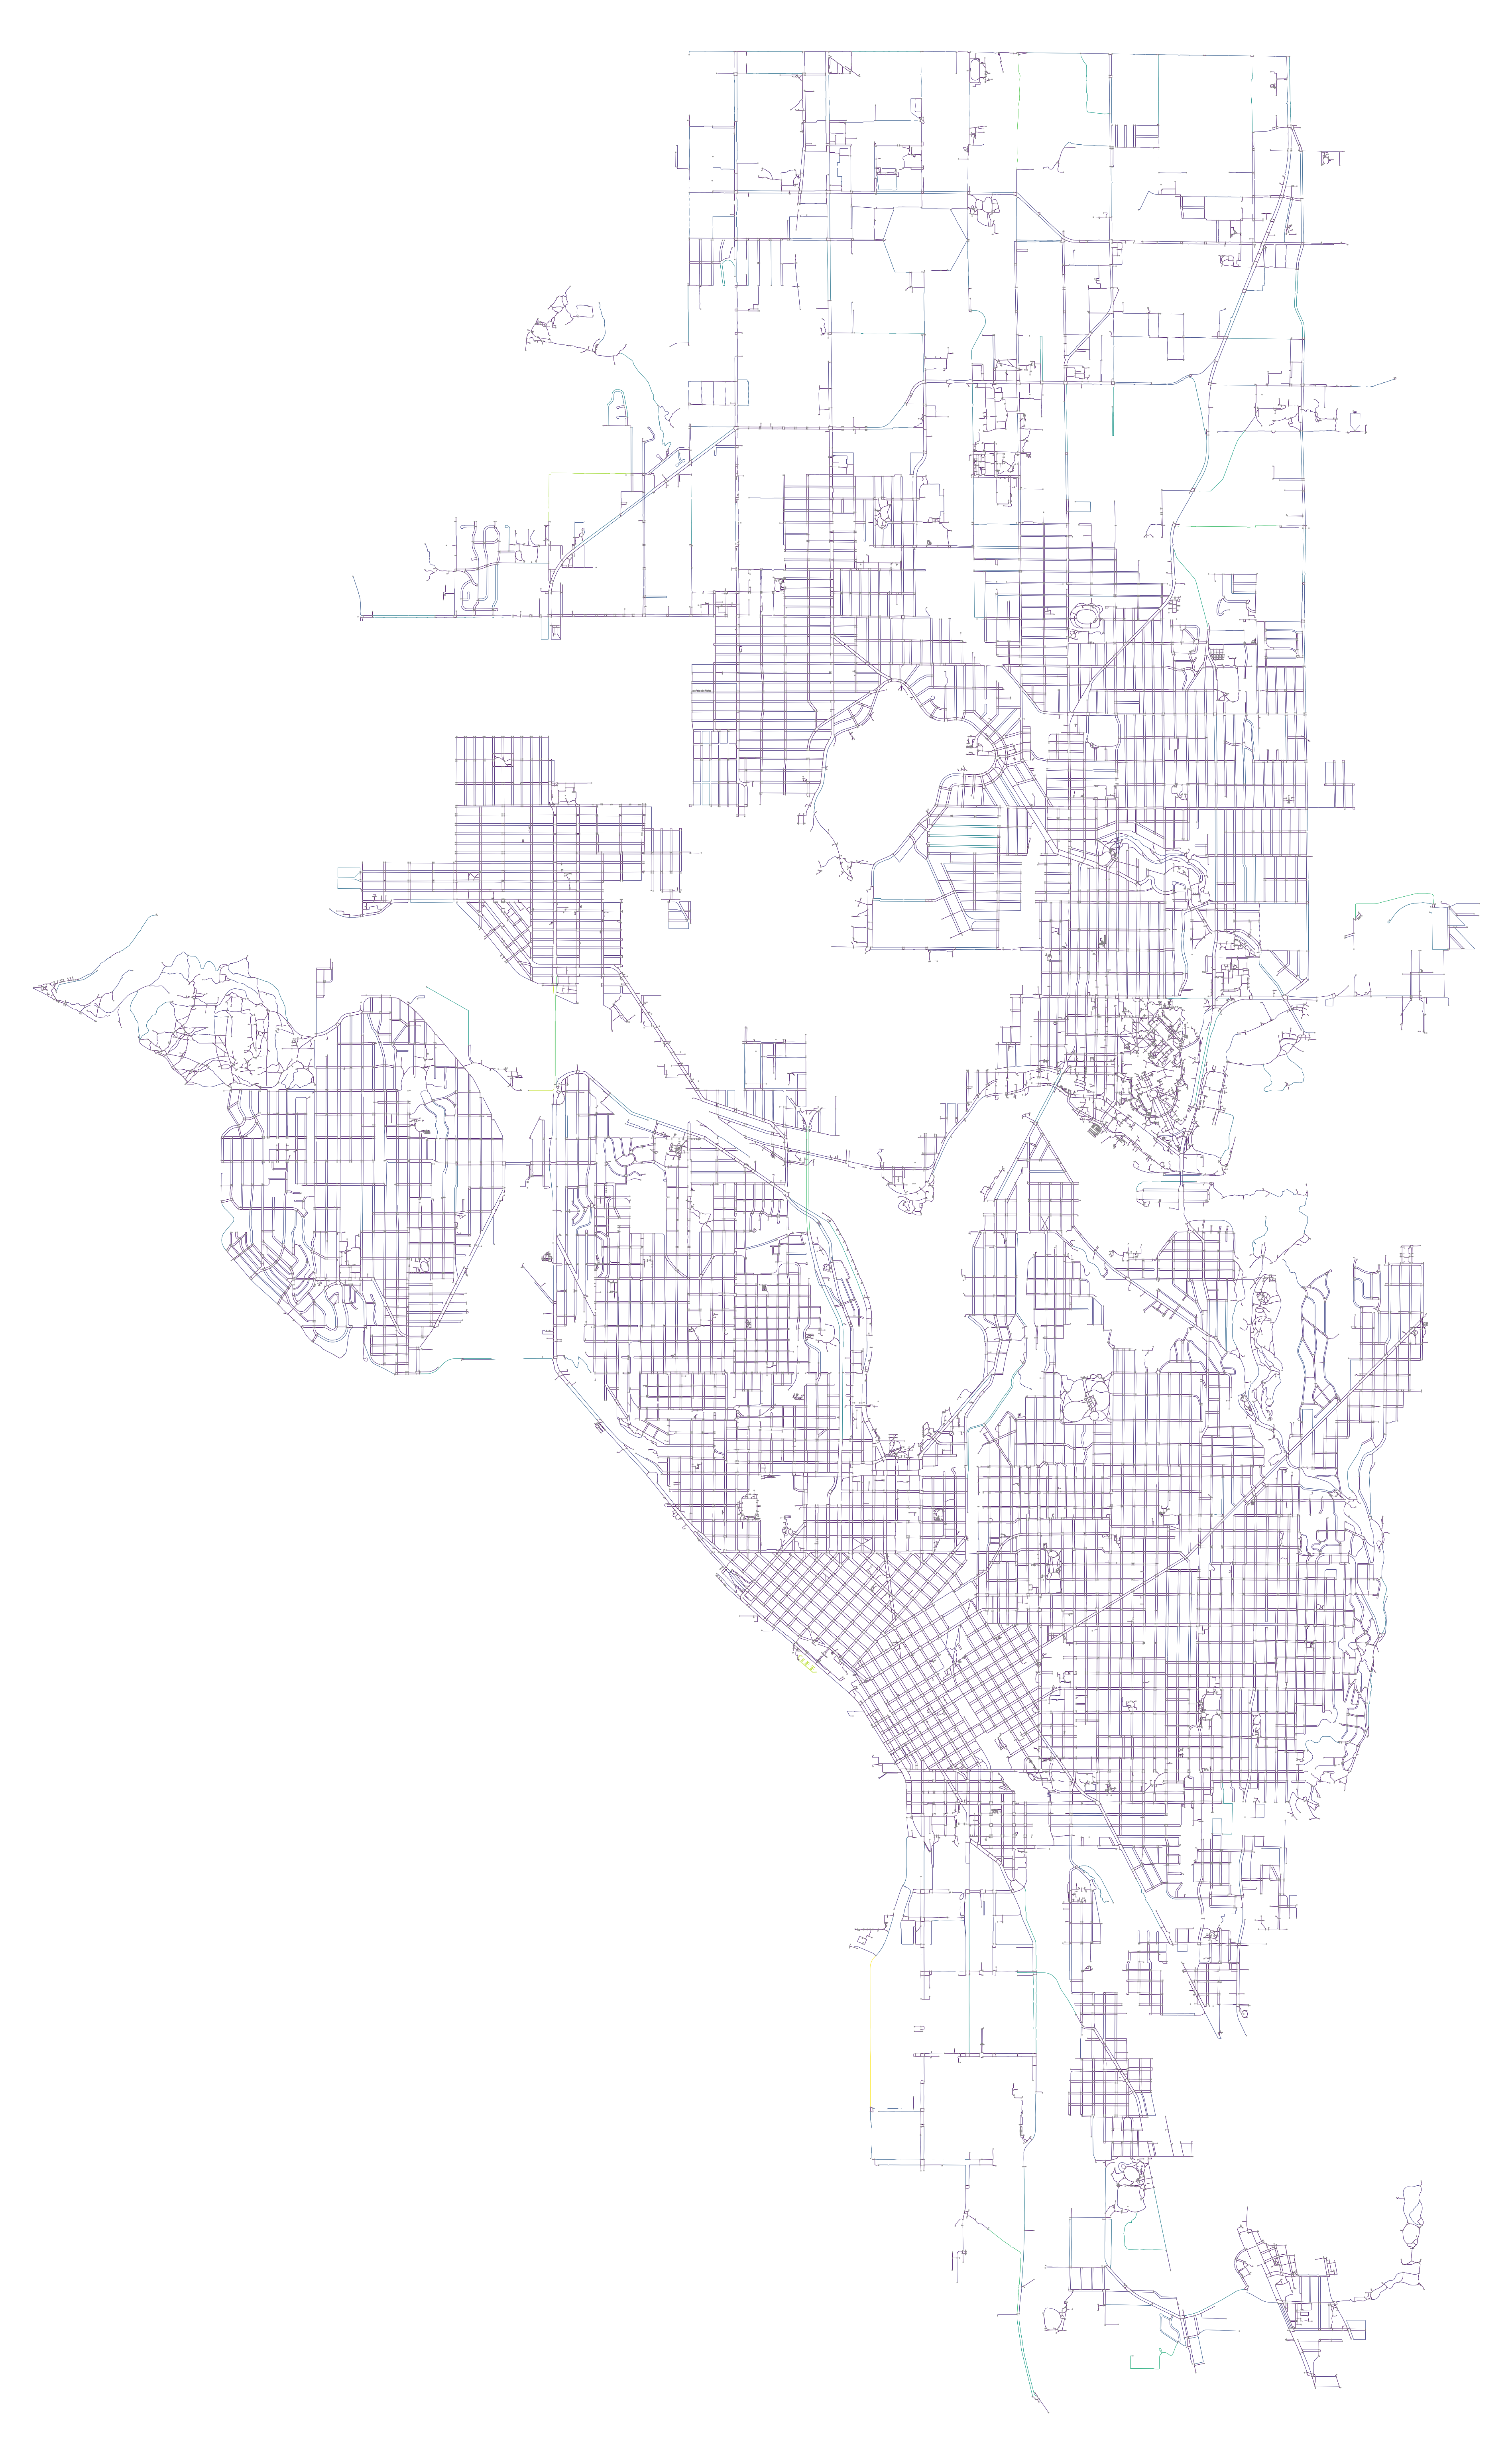

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

In [275]:
ox.plot_graph(
    G,
    figsize=(80, 80),
    bgcolor="#fff", edge_color=edge_colors, node_color="#888",
    node_size=5, edge_linewidth=0.5
)

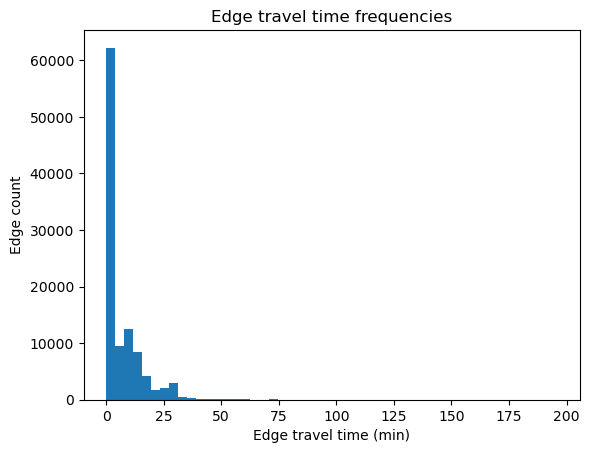

In [276]:
plt.xlabel("Edge travel time (min)")
plt.ylabel("Edge count")
plt.title("Edge travel time frequencies")
plt.hist(edge_times, bins=50);

## Generating random walks

In [277]:
import random

In [278]:
# Keep visiting nodes till we hit something in end_nodes
def random_walk(start, timeout=60*60*24):
    """
    Do a random walk starting from node <start> (node id)
        until we hit a boba shop, time out, or hit a dead end.

    Timeout is in seconds. If we haven't reached a boba shop or
        a dead end by that time, we terminate.
    
    Returns an ordered tuple:
        [0] route:        list of tuples (node id, time)
        [1] total_time:   float, end time
        [2] total_dist:   float, distance travelled
        [3] flag:         "success", "timeout", or "deadend"
    """
    cur = start
    route = []
    cur_time = 0
    cur_dist = 0

    while True:
        route.append((cur, cur_time))

        if cur in end_nodes:  # Found a boba shop!
            return route, cur_time, cur_dist, "success"
        if cur_time >= timeout:  # Time exceeded
            return route, cur_time, cur_dist, "timeout"
        if len(adj[cur]) == 0:  # Dead end
            return route, cur_time, cur_dist, "deadend"

        # Select a random neighbor to walk to
        nbr, t, dist = random.choices(adj[cur], k=1)[0]
        cur_time += t
        cur_dist += dist
        cur = nbr

In [279]:
def random_walks(start, n_walks=1000, flag_filter="success", timeout=60*60*24, verbose=False):
    """
    Do a lot of random walks. Only accept those with flag <filter>, unless
        <filter> is None, in which case we accept everything.
    """
    res = []

    iterable = tqdm(range(n_walks)) if verbose else range(n_walks)
    for _ in iterable:
        walk = random_walk(start, timeout)
        if flag_filter != None and walk[-1] != flag_filter:
            continue

        res.append(walk)

    return list(zip(*res))

In [280]:
startY, startX = ox.geocoder.geocode("City Hall, Seattle, USA")
start = ox.nearest_nodes(G, startX, startY)

print(f"Starting at osmid={start}:")
print(nodes.loc[start])

print(f"\n{nodes.loc[start].y}, {nodes.loc[start].x}")

Starting at osmid=10744555665:
y                                     47.602326
x                                   -122.329893
street_count                                  3
highway                                     NaN
ref                                         NaN
geometry        POINT (-122.3298928 47.6023257)
Name: 10744555665, dtype: object

47.6023257, -122.3298928


In [ ]:
walks = random_walks(start, n_walks=1000, verbose=True)
routes = walks[2]

Walking from Lakeside School...


100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Walking from City Hall...


100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


Walking from Pike Place Market...


100%|██████████| 100/100 [00:01<00:00, 71.78it/s]


Walking from University of Washington...


100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


Walking from Space Needle...


100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


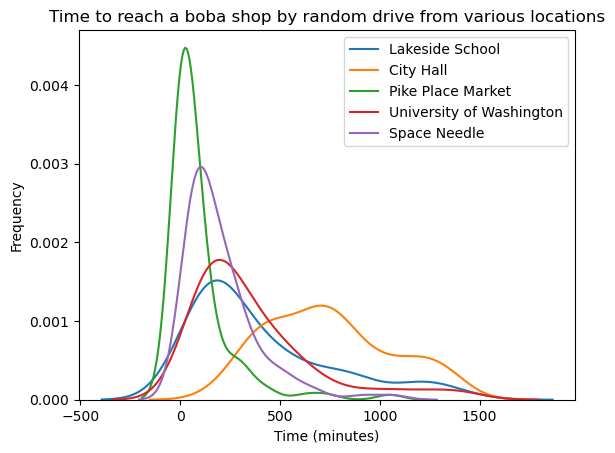

In [285]:
plt.xlabel("Time (minutes)")
plt.ylabel("Frequency")
plt.title("Time to reach a boba shop by random drive from various locations")

def boba_min_distr(placename):
    print(f"Walking from {placename}...")
    startY, startX = ox.geocoder.geocode(placename + ", MA, USA")
    start = ox.nearest_nodes(G, startX, startY)

    walks = random_walks(start, n_walks=100, verbose=True)
    time_mins = np.array(walks[1]) / 60

    sns.distplot(time_mins, hist=False, label=placename)

for place in ["Lakeside School", "City Hall", "Pike Place Market", "University of Washington", "Space Needle"]:
    boba_min_distr(place)

plt.legend()

# plt.hist(time_mins[time_mins < 180], bins=50);

KeyError: 61327823

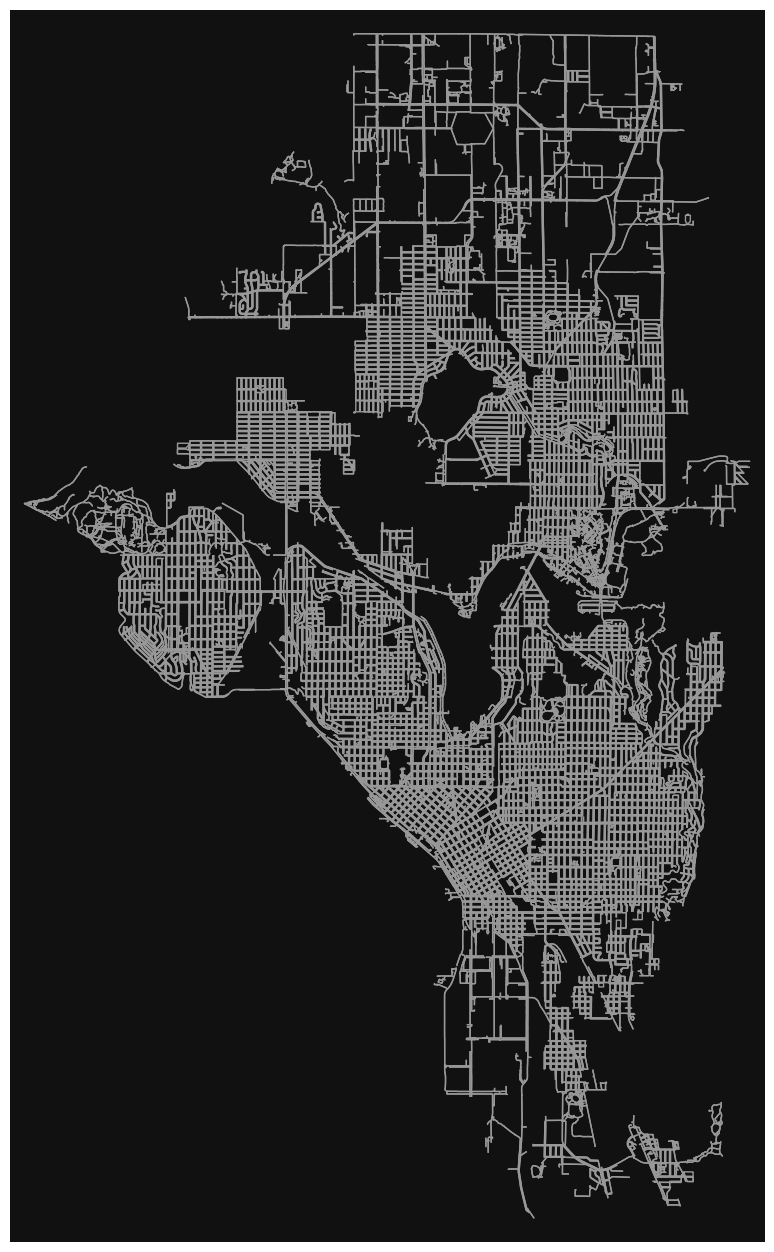

In [286]:
# Let's plot this
ox.plot.plot_graph_routes(
    G, [[p[0] for p in path] for path in walks[0][:2]], route_linewidth=0.1, route_alpha=0.5,
    figsize=(16, 16), node_size=0
)